In [1]:
import scanpy as sc
#import anndata as AN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

In [2]:
# load data
meta = np.load('./processed_data/single_cell/filtered_meta.npy', allow_pickle=True)
meta_names = np.load('./processed_data/single_cell/meta_names.npy', allow_pickle=True)
features = np.load('./processed_data/single_cell/features.npy')
counts = np.memmap('./processed_data/single_cell/filtered_counts.npy', mode='r+', shape=(meta.shape[0], features.shape[0]), dtype='int16')
index_genes = np.load('./processed_data/single_cell/marker_indices.npy')

In [3]:
# subset
index = meta[:,np.where(meta_names=='keep_cells_all_per_celltype')[0][0]].astype(bool)
index2 = meta[:,np.where(meta_names=='keep_cells_gaussian')[0][0]].astype(bool)
index_all = index&index2

# metadata
META = meta[index_all]
META_df = pd.DataFrame(META)
META_df.columns = meta_names
META_df.index = META_df['barcodes']
META_df['total_counts'] = META_df['total_counts'].astype(int)
META_df['mito_fractions'] = META_df['mito_fractions'].astype(float)
META_df = pd.get_dummies(META_df, columns=['seq_batch'], drop_first=True)
META_df = pd.get_dummies(META_df, columns=['projid'], drop_first=True)

# features
FEATURES_df = pd.DataFrame(features[index_genes])
FEATURES_df.columns = ['Gene', 'ID']
FEATURES_df.index = FEATURES_df['Gene']

# counts
COUNTS = counts[index_all][:,index_genes]
COUNTS_df = pd.DataFrame(COUNTS)
COUNTS_df.columns = FEATURES_df['Gene']
COUNTS_df.index = META_df['barcodes']

/state/partition1/slurm_tmp/23513754.0.0/ipykernel_76704/459307264.py:14: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  META_df = pd.get_dummies(META_df, columns=['projid'], drop_first=True)


In [4]:
# make adata
adata = sc.AnnData(X=COUNTS, obs=META_df, var=FEATURES_df)
adata.uns['metadata'] = META_df
adata.var_names_make_unique(join='.')
adata.obs_names_make_unique(join='.')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

In [6]:
L = list(META_df.columns[[x.split('_')[0]=='projid' for x in META_df.columns]])
#L = ['total_counts', 'mito_fractions', 'seq_batch_JBM']

In [7]:
sc.pp.regress_out(adata, L, n_jobs=94)


/home/gridsan/djuna/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [8]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [9]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.5)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDepr

In [10]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


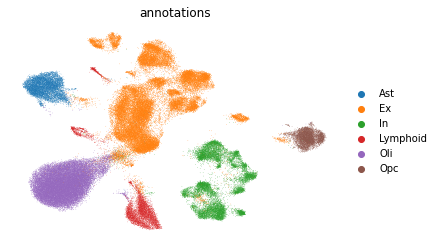

In [11]:
out = sc.pl.umap(adata, color=['annotations'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)
    

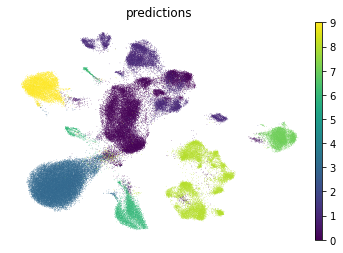

In [12]:
out = sc.pl.umap(adata, color=['predictions'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


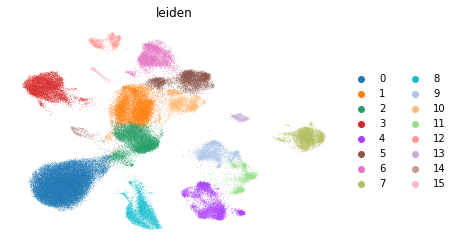

In [13]:
out = sc.pl.umap(adata, color=['leiden'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


In [14]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home

In [21]:
markers = pd.read_csv('./processed_data/single_cell/brain_marker_genes.csv')
#markers = markers.loc[markers['major_celltype']!='Lymphoid']
markers.head()

,Unnamed: 0,marker,major_celltype
0,Ast.1,ABLIM1,Ast
1,Ast.2,AC002429.2,Ast
2,Ast.3,AC008957.2,Ast
3,Ast.4,AC074363.1,Ast
4,Ast.5,ACOT11,Ast


In [22]:
scores = adata.uns['rank_genes_groups']['scores']
names = adata.uns['rank_genes_groups']['names']
sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T

In [23]:
celltypes = np.unique(markers['major_celltype'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['major_celltype']==np.unique(celltypes)[i]]['marker'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 

In [24]:
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


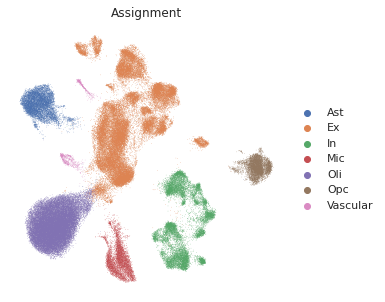

In [25]:
import seaborn as sns
width = 5
height = 5
sns.set(rc = {'figure.figsize':(width, height)})
out = sc.pl.umap(adata, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


In [27]:
np.unique(adata.obs['Assignment'], return_counts=True)

(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc', 'Vascular'], dtype=object),
 array([ 8194, 42911, 14017,  5521, 31099,  5925,  1012]))

In [28]:
import matplotlib.pyplot as plt
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(np.unique(assignments)))]
dictionary = dict(zip(np.unique(assignments), colors))

/state/partition1/slurm_tmp/23513754.0.0/ipykernel_76704/2153427995.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


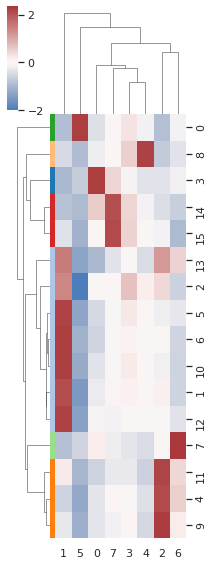

In [29]:
sns.clustermap(celltype_scores, row_colors = [dictionary[x] for x in assignments], z_score=0, cmap="vlag", center=0, figsize=(3,8))

In [70]:
keep_genes = np.load('./processed_data/single_cell/keep_genes.npy')
index_genes = np.sum(keep_genes, axis=0)>0
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='r+', shape=(meta.shape[0], features.shape[0]), dtype='float')

In [71]:
# save to sparse matrix (save the new celltype annotations and make sure to subset accordingly)

import scipy.io as sio
from scipy.sparse import csr_matrix

counts_sparse = csr_matrix(counts[index_all][:,index_genes])
logcounts_sparse = csr_matrix(logcounts[index_all][:,index_genes])

sio.mmwrite("./processed_data/single_cell/counts.mtx",counts_sparse)
sio.mmwrite("./processed_data/single_cell/logcounts.mtx",logcounts_sparse)


In [69]:
np.max(logcounts[meta[:,-18]=='171013Tsa',])

0.0

In [62]:
logcounts

(124282, 36601)

In [36]:
# save feature data
df = pd.DataFrame(features[index_genes])
df.to_csv("./processed_data/single_cell/rowData.csv")

In [46]:
celltypes

array(['Ast', 'Ex', 'In', 'Lymphoid', 'Mic', 'Oli', 'Opc', 'Vascular'],
      dtype=object)

In [53]:
# save obs data
df = pd.DataFrame(meta[index_all])
df.columns = meta_names
df['annotations2'] = np.array(adata.obs['Assignment'])
df['leiden_clusters'] = np.array(adata.obs['leiden'])
df['x'] = adata.obsm['X_umap'][:,0]
df['y'] = adata.obsm['X_umap'][:,1]   
df.to_csv("./processed_data/single_cell/colData.csv")

In [48]:
# save celltype score info
df = pd.DataFrame(celltype_scores)
df.columns = celltypes
df.to_csv("./processed_data/single_cell/celltype_scores.csv")

In [54]:
df

,barcodes,index,projid,sample_id,molecule_h5,study,pmi,age_death,msex,amyloid,...,keep_cells_gaussian,predictions,gaussian_liklihood,annotations,total_counts,mito_fractions,annotations2,leiden_clusters,x,y
0,AAACCCAAGTAAACGT-1,0,10485914,D20-7432,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,6.0,84.435318,1,0.0,...,True,7,268.395388,Opc,8992,0.010454,Opc,7,17.002806,4.753179
1,AAACCCACAGAATTCC-1,0,10485914,D20-7432,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,6.0,84.435318,1,0.0,...,True,9,270.337971,Ast,18140,0.003804,Ast,3,-2.643841,11.595880
2,AAACGCTCAGAGTCAG-1,0,10485914,D20-7432,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,6.0,84.435318,1,0.0,...,True,3,258.093871,Oli,560,0.033929,Oli,0,-0.113857,2.885270
3,AAAGAACAGAATACAC-1,0,10485914,D20-7432,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,6.0,84.435318,1,0.0,...,True,3,261.462122,Oli,1866,0.026259,Oli,0,-1.881512,1.998334
4,AACAAGATCAAGATAG-1,0,10485914,D20-7432,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,6.0,84.435318,1,0.0,...,True,9,270.152764,Ast,9326,0.00311,Ast,3,-2.946994,11.175462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108674,TTTCCTCGTTAAGTAG-1,15,20282398,D17-8786,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,4.083333,87.449692,0,5.69125,...,True,0,274.972967,Ex,36646,0.046226,Ex,10,7.051618,10.256038
108675,TTTGCGCCAGCGTTCG-1,15,20282398,D17-8786,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,4.083333,87.449692,0,5.69125,...,True,3,252.303667,Oli,940,0.010638,Oli,0,-0.403532,0.824648
108676,TTTGCGCTCTTACCTA-1,15,20282398,D17-8786,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,4.083333,87.449692,0,5.69125,...,True,1,275.101189,Ex,27804,0.029672,Ex,12,2.231446,15.937909
108677,TTTGGTTAGACACGAC-1,15,20282398,D17-8786,/home/gridsan/djuna/homer/github/ABCA7lof2/raw...,ROS,4.083333,87.449692,0,5.69125,...,True,3,270.457027,Oli,2025,0.017284,Oli,0,-2.512164,-0.839972


In [44]:
# np.save('./processed_data/single_cell/annotations.npy', adata.obs['Assignment'])
# np.save('./processed_data/single_cell/leiden.npy', adata.obs['leiden'])
# np.save('./processed_data/single_cell/scores.npy', celltype_scores)

In [20]:
# # save the coordinates
# import numpy as np
# import pandas as pd
# df = pd.DataFrame(np.load('./processed_data/single_cell/coords.npy'))
# df = df.iloc[index_all]
# df['LoF'] = np.array(META_df['ABCA7LoF'])
# df['seq_batch'] = np.array(META_df['seq_batch'])
# df.to_csv('./processed_data/single_cell/coords.csv')

IndexError: Boolean index has wrong length: 124279 instead of 114274